## Compare Synthetic with Observations

per pixel error estimates


In [ ]:
# import matplotlib as mpl
# mpl.rcParams.update(mpl.rcParamsDefault)

In [1]:
import folium
import xskillscore as xs
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sb

import contextily as ctx
from matplotlib.ticker import FormatStrFormatter

import odc.geo.xr
from odc.geo.xr import assign_crs

%matplotlib inline


In [2]:
model_var='LST'
feat = 'CLIM'
base = '/g/data/os22/chad_tmp/climate-carbon-interactions/data/'

In [3]:
yy = xr.open_dataset(f'{base}synthetic/{model_var}/{model_var}_{feat}_synthetic_5km_monthly_1982_2022.nc')[model_var]
obs = xr.open_dataset(f'{base}{model_var}_harmonization/LGBM/{model_var}_{feat}_LGBM_5km_monthly_1982_2022_wGaps.nc')[model_var]

if model_var=='LST':
    yy = yy-273.15
    obs = obs-273.15

obs = obs.sel(time=yy.time)
gaps_mask = ~np.isnan(obs)
 
yy = yy.where(gaps_mask)

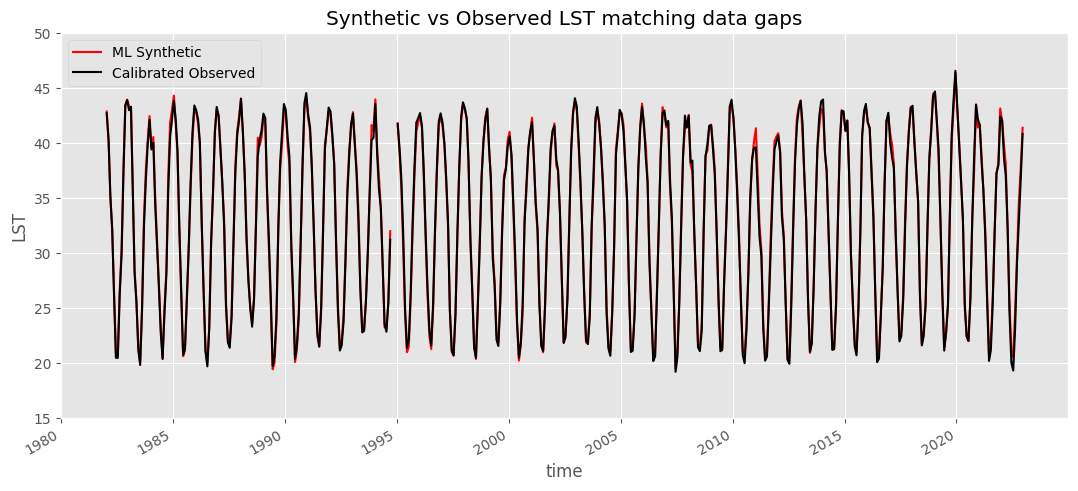

In [8]:
with plt.style.context('ggplot'):
    fig, ax = plt.subplots(1,1, figsize=(13,5))
    yy.mean(['latitude','longitude']).plot(ax=ax, label='ML Synthetic', color='red')
    obs.mean(['latitude','longitude']).plot(ax=ax, label='Calibrated Observed', color='black')
    if model_var =='NDVI':
        ax.set_ylim(0.20, 0.40)
    if model_var =='LST':
        ax.set_ylim(15, 50)
    ax.legend()
    ax.set_title('Synthetic vs Observed '+model_var+ ' matching data gaps')

fig.savefig("/g/data/os22/chad_tmp/climate-carbon-interactions/results/figs/syn_vs_obs_"+model_var+"_timeseries.png",
            bbox_inches='tight', dpi=300)
# plt.show()

### Error metrics

In [5]:
pred_mean = yy.mean('time')
obs_mean = obs.mean('time')
obs_mask = ~np.isnan(obs_mean)
low_ndvi_mask = xr.where(obs.mean('time')<0.10,0, 1)
pred_mean = pred_mean.where(obs_mask)
pred_mean = pred_mean.where(low_ndvi_mask)
obs_mean = obs_mean.where(low_ndvi_mask)

In [6]:
corr = xr.corr(obs, yy, dim='time').rename('Pearson Correlation')
corr = corr.where(low_ndvi_mask)
corr = corr.where(obs_mask)

rmse = xs.rmse(obs,yy, dim='time', skipna=True).rename('RMSE')
rmse = rmse.where(low_ndvi_mask)
rmse = rmse.where(obs_mask)

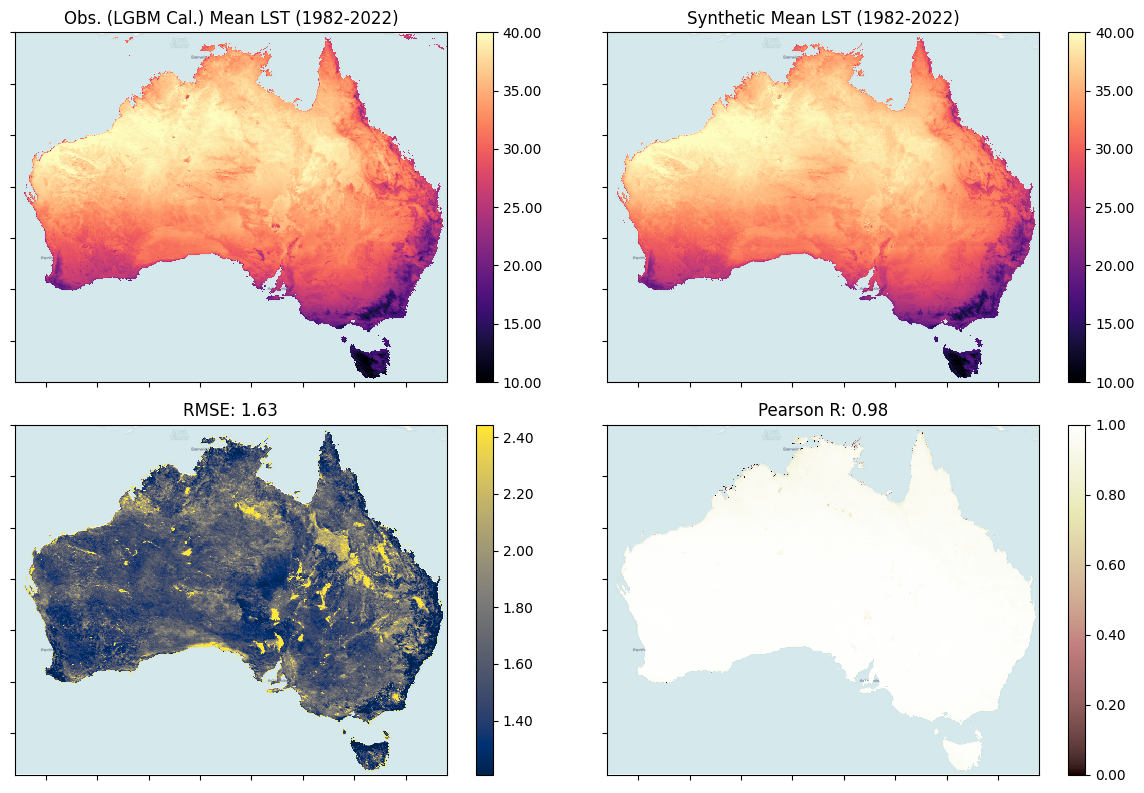

In [7]:
corr_data = [obs_mean, pred_mean, rmse, corr]

products=['Obs. (LGBM Cal.) Mean '+model_var+' (1982-2022)', 'Synthetic Mean '+model_var+ ' (1982-2022)', 
          f'RMSE: '"{:.2f}".format(rmse.mean().values),
          f'Pearson R: '"{:.2f}".format(corr.mean().values)
         ]

if model_var=='NDVI':
    cmaps = ['gist_earth_r', 'gist_earth_r', 'cividis', 'pink']

if model_var=='LST':
    cmaps = ['magma', 'magma', 'cividis', 'pink']

fig,axes = plt.subplots(2,2, figsize=(12,8), sharey=True, sharex=True)

for ax, ds, n, cmap in zip(axes.ravel(), corr_data, products, cmaps):
    if cmap=='pink':
        vmin=0
        vmax=1.0
        im = ds.plot(vmin=vmin, vmax=vmax, cmap=cmap, ax=ax, add_colorbar=False)
    else:
        if 'LST' in n:
            im = ds.plot(vmin=10, vmax=40, cmap=cmap, ax=ax, add_colorbar=False)
        else:
            im = ds.plot(robust=True, cmap=cmap, ax=ax, add_colorbar=False)
    cbar = plt.colorbar(im, ax=ax, shrink=1.0)
    cbar.ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ctx.add_basemap(ax, source=ctx.providers.CartoDB.Voyager, crs='EPSG:4326', attribution='', attribution_size=1)
    ax.set_title(f'{n}')
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.set_yticklabels([])
    ax.set_xticklabels([])
plt.tight_layout()
fig.savefig("/g/data/os22/chad_tmp/climate-carbon-interactions/results/figs/Error_metrics_synthetic_"+model_var+".png",
            bbox_inches='tight', dpi=300)


In [ ]:
# m = folium.Map(control_scale = True)

# # assign_crs(corr, crs='EPSG:4326').odc.add_to(m, vmin=0.5, vmax=1.0, cmap='magma')
# assign_crs(mae, crs='EPSG:4326').odc.add_to(m, robust=True, cmap='inferno')

# # Zoom map to Australia
# m.fit_bounds(corr.odc.map_bounds())

# tile = folium.TileLayer(
#         tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
#         attr = 'Esri',
#         name = 'Esri Satellite',
#         overlay = True,
#         control = True
#        ).add_to(m)

# folium.LayerControl().add_to(m)
# display(m)